In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [28]:
# OTher crime data set
# https://www.kaggle.com/mchirico/chtpd/version/22/data
# https://www.kaggle.com/c/sf-crime/data
# https://www.kaggle.com/marshallproject/crime-rates/data

# Reading - https://afnan.io/2017-10-31/using-k-means-clustering-in-scikit-learn/

In [29]:
# Other implementation
# https://github.com/LJANGN/K-means-clustering-on-US-crime-data/blob/master/kmeans_US_crime_data-FINAL.ipynb

In [30]:
Crime = pd.read_csv('../../data/crime_data.csv')
del Crime['cluster'] # remove cluster
Crime.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


## Check for missing values

In [31]:
Crime.isnull().sum()

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [32]:
# sns.pairplot(Crime)

- There seems to be some relationship between `Assault` and `Murder`

[<matplotlib.text.Text at 0x119362e10>, <matplotlib.text.Text at 0x1183e4b00>]

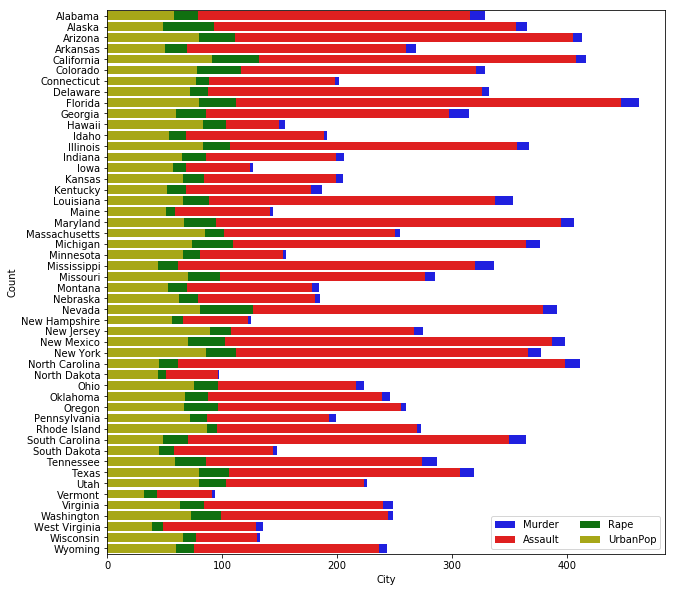

In [33]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

Copy = Crime.copy(deep=True)
Copy['Rape'] = Copy['Rape'] + Copy['UrbanPop']
Copy['Assault'] = Copy['Assault'] + Copy['Rape']
Copy['Murder'] = Copy['Assault'] + Copy['Murder']

sns.barplot(y="City", x="Murder", data= Copy, label="Murder", color="b")
sns.barplot(y="City", x="Assault", data= Copy, label="Assault", color="r")
sns.barplot(y="City", x="Rape", data= Copy, label="Rape", color="g")
sns.barplot(y="City", x="UrbanPop", data= Copy, label="UrbanPop", color="y")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Count", xlabel="City")
# sns.despine(left=True, bottom=True)

## Applying pca

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

num_of_PC = 4
PC_names = [ "PC" + str(i) for i in range(num_of_PC)]
PC_components_names = [ "Z" + str(i) for i in range(num_of_PC)]
loading_component_names = [ "theta" + str(i) for i in range(len(Crime.columns) -1)]

__std_X = StandardScaler().fit_transform(Crime[['Murder', 'Assault', 'UrbanPop', 'Rape']])
std_X = pd.DataFrame(__std_X, columns=['Murder', 'Assault', 'UrbanPop', 'Rape'])
pca = PCA(n_components= num_of_PC, random_state = 0)
principalComponents = pca.fit_transform(std_X)
principalDf = pd.DataFrame( data = principalComponents, columns = PC_names)

In [35]:
principalDf.head(1)

,PC0,PC1,PC2,PC3
0,0.985566,1.133392,-0.444269,0.156267



- Z1 = $\theta_0$ * Murder + $\theta_1$ * Assault + $\theta_2$ * UrbanPop + $\theta_3$ * Rape
- Z2 = $\theta_0$ * Murder + $\theta_1$ * Assault + $\theta_2$ * UrbanPop + $\theta_3$ * Rape

In [36]:
pd.DataFrame(pca.components_, 
             columns=loading_component_names,
             index=PC_components_names
            )

,theta0,theta1,theta2,theta3
Z0,0.535899,0.583184,0.278191,0.543432
Z1,0.418181,0.187986,-0.872806,-0.167319
Z2,-0.341233,-0.268148,-0.378016,0.817778
Z3,0.649228,-0.743407,0.133878,0.089024


### Checking the variance explained

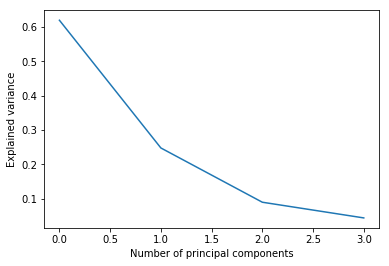

In [37]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance')

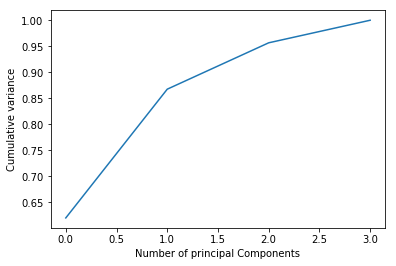

In [38]:
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_exp_var)
plt.xlabel('Number of principal Components')
plt.ylabel('Cumulative variance')

- Nearly 87% of information is being explained by 2 principal components. So, let's build pca with 2 components.

In [39]:
selected_n_component = 2
final_pca = PCA(n_components= selected_n_component, random_state = 0)
principalComponents = final_pca.fit_transform(std_X)
trans_df = pd.DataFrame( data = principalComponents, columns = ['PC0', 'PC1'])
trans_df.head(1)

,PC0,PC1
0,0.985566,1.133392


Alright, we understand that 2 principal component should be good enough to summarize the entire dataset. But, what do they mean practically? We need to figure out their practical/real world aspects as well, so that we can rename them.


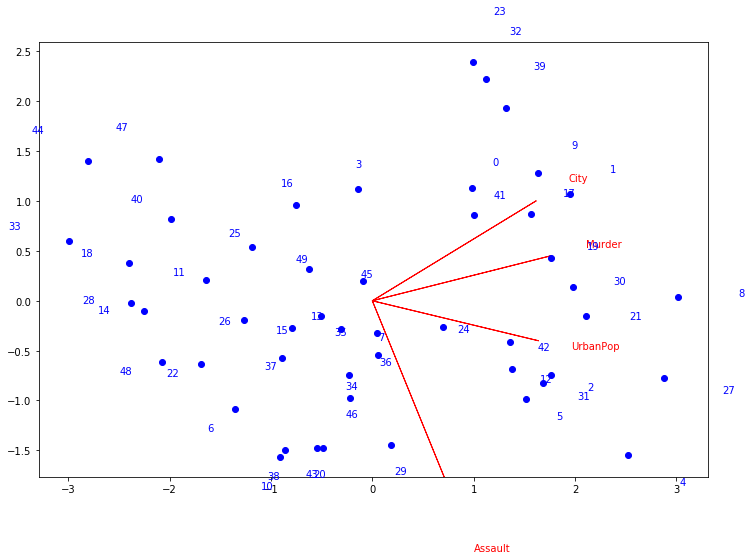

In [40]:
def render_biplot(xvector, yvector, xs, ys, dat):
    fig, ax = plt.subplots(figsize=(12, 8))
    for i in range(len(xvector)):
    # arrows project features (ie columns from csv) as vectors onto PC axes
        ax.arrow(0, 
                  0, 
                  xvector[i]*max(xs), 
                  yvector[i]*max(ys), 
                  color='r', 
                  width=0.0005, 
                  head_width=0.0025)

        ax.text(xvector[i]*max(xs)*1.2, 
                 yvector[i]*max(ys)*1.2,
                 list(dat.columns.values)[i], 
                 color='r')

    for i in range(len(xs)):
    # circles project documents (ie rows from csv) as points onto PC axes
        ax.plot(xs[i], ys[i], 'bo')
        ax.text(xs[i]*1.2, ys[i]*1.2, list(dat.index)[i], color='b')
    
    return plt;

render_biplot(final_pca.components_[0],
              final_pca.components_[1],
              trans_df['PC0'],
              trans_df['PC1'],
              Crime
             ).show()

## Interpretation
 - `Murder` and `Assault` seems to come hand by hand. Probably an assault is followed by Murder.
 - `Murder` and `Assault` seems not to be related to `UrbanPopulation`.
 - `UrbanPop` seems to be our first Principal component and mix of `Murder`, `Assault`, `Rape` seems to be other. 
 - Second PC should be called as `Score of crime`.
 - First PC should be called as `Score of urbanisation`.

## Applying kmeans clustering algorithm

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import grid_search
from sklearn.metrics import silhouette_score

std_crime = trans_df.copy(deep=True)

parameters = {
    'n_clusters': np.arange(2,6),
    'n_init': [50, 100],
    'max_iter': [300, 600, 900]
}

In [42]:
def run_parameter_tuning():
    kmeans = KMeans(random_state=0)
    clf = grid_search.GridSearchCV(kmeans, parameters)
    clf.fit(std_crime)
    labels = clf.predict(std_crime)
    score = silhouette_score(std_crime, labels)
    print(score)
    print('Parameters are ', clf.best_params_)
    
#run_parameter_tuning()

#### Run kmeans on our tuned parameter

In [43]:
best_kmeans = KMeans(random_state=0, max_iter=300, n_clusters=5, n_init=50)
best_kmeans.fit_predict(std_crime)
best_kmeans.inertia_
labels = best_kmeans.predict(std_crime)

In [44]:
Crime.head(1)

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2


## Visualisation of clusters

In [45]:
num_of_cities = Crime['City'].shape[0]
cities = np.array(Crime['City']).reshape(num_of_cities, 1)

labels = pd.Series(labels).reshape(50,1)
# orig_crime = scaler.inverse_transform(std_crime)
vis_data = np.concatenate((cities, std_crime, labels), axis=1)
vis_df = pd.DataFrame(vis_data, columns=['City', 'PC0', 'PC1', 'labels'])
vis_df.head(3)

/Users/ttn/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


,City,PC0,PC1,labels
0,Alabama,0.985566,1.13339,3
1,Alaska,1.95014,1.07321,3
2,Arizona,1.76316,-0.745957,0


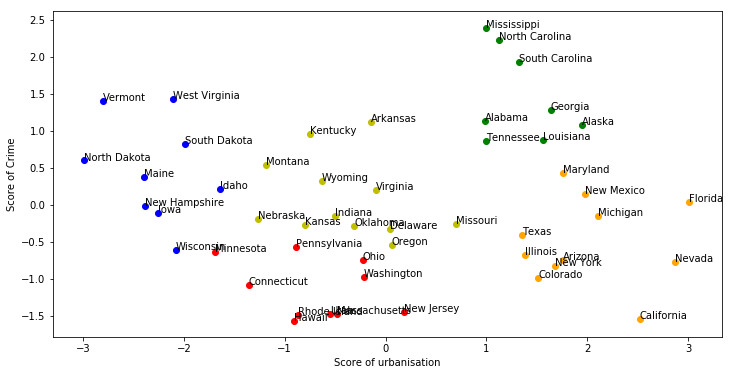

In [46]:
def get_col(df, category, col):
    return df[df['labels'] == category][col].tolist()

# get_murder(vis_df, 1, 'Murder').tolist()
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(get_col(vis_df, 1, 'PC0'), get_col(vis_df, 1, 'PC1'), c = 'r')
ax.scatter(get_col(vis_df, 2, 'PC0'), get_col(vis_df, 2, 'PC1'), c = 'b')
ax.scatter(get_col(vis_df, 3, 'PC0'), get_col(vis_df, 3, 'PC1'), c = 'g')
ax.scatter(get_col(vis_df, 4, 'PC0'), get_col(vis_df, 4, 'PC1'), c = 'y')
ax.scatter(get_col(vis_df, 0, 'PC0'), get_col(vis_df, 0, 'PC1'), c = 'orange')

for index, row in vis_df.iterrows():
    ax.annotate(row['City'], (row['PC0'], row['PC1']))

plt.xlabel('Score of urbanisation')
plt.ylabel('Score of Crime')

Create a city vs cluster graph